# Selección de variables, Lasso

#### Importamos las librerias necesarias

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as ts

In [6]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
                            
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV

#### Leemos el dataset guardado de nuestro EDA

In [4]:
Directory = 'df_core.csv'
df_core = pd.read_csv(Directory)
# df_core = df_core.set_index("Date")
df_core

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
1999-01-01,1999,1,1,0,2,2,21,2,1,5,...,1,6,1989,1,0,18,11,2,2,1
1999-01-01,1999,1,1,0,2,2,21,2,1,5,...,1,6,1989,2,0,16,13,2,2,2
1999-01-01,1999,1,1,0,2,2,21,2,1,5,...,2,1,1991,1,1,16,11,1,2,1
1999-01-01,1999,1,1,0,2,2,34,2,4,3,...,2,1,1992,1,0,18,11,1,2,1
1999-01-01,1999,1,1,0,2,2,34,2,4,3,...,1,1,1998,1,0,30,11,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-07,2014,12,7,23,2,1,21,2,5,5,...,1,1,2000,1,1,17,11,2,2,1
2014-12-07,2014,12,7,23,2,1,6,1,4,3,...,1,1,2013,1,1,13,11,1,2,1
2014-12-07,2014,12,7,23,2,1,6,1,4,3,...,99,1,2000,1,1,19,99,2,2,3
2014-12-07,2014,12,7,23,2,1,6,2,1,1,...,1,1,2014,1,0,54,11,1,2,1


## Selección de variables

Consideramos eliminar todas las variables que no tengan que ver con el propio vehículo, teniendo en cuenta para el modelo unicamente cómo se da el accidente y las condiciones externas en las que se encuentran los vehiculos involucrados. No tendremos en cuenta la identificación de las personas implicadas ni las cualidades del vehiculo.

In [7]:
df_core = df_core.drop(['P_ID','P_SEX','P_AGE','P_PSN','P_ISEV','P_SAFE','P_USER','V_TYPE','V_YEAR', 'V_ID'], axis=1)

Reenombramos la variable target de forma que los accidentes no mortales pasen de ser '2' a ser '0'. Esto nos permite un mejor tratamiento de los datos.

In [8]:
csev_clean = {"C_SEV":{2: 0, 1:1}}
df_core.replace(csev_clean, inplace=True)

df_core.C_SEV.value_counts()

0    5761772
1      98633
Name: C_SEV, dtype: int64

#### Unimos algunas etiquetas en una sola para ser más eficientes a la hora de modelar 

Por ejemplo, estudiamos la variable de vehiculos involucrados en el accidente, cuando se ven mas de cinco coches implicados, la cantidad de registros es mínima, por lo tanto creamos una nueva categoria "mas de cinco coches involucrados"

Haremos la transformación y luego escribiremos la nueva leyenda de cada variable.

In [9]:
cvehs_clean = {"C_VEHS":{7:6, 8:6, 9:6, 10:6, 11:6, 12:6, 13:6, 14:6, 15:6,
                        16:6, 17:6, 18:6, 19:6, 20:6, 21:6, 22:6, 23:6, 24:6,
                        25:6, 26:6, 27:6, 28:6, 29:6, 30:6, 31:6, 32:6, 33:6,
                        34:6, 35:6, 36:6, 37:6, 38:6, 39:6, 40:6, 41:6, 43:6,
                        44:6, 46:6, 51:6, 54:6, 56:6, 57:6, 58:6, 71:6, 72:6, 77:6}}
df_core.replace(cvehs_clean, inplace=True)

df_core.C_VEHS.value_counts()

2    4799049
1     587278
3     352189
4      86397
5      21217
6      14275
Name: C_VEHS, dtype: int64

- 1-5: 1-5 vehículos involucrados
- 6: > 5 vehículos involucrados

In [10]:
crcfg_clean = {"C_RCFG":{5:4, 6:4, 7:4, 8:4, 9:5, 10:6, 11:6, 12:6}}
df_core.replace(crcfg_clean, inplace=True)

df_core.C_RCFG.value_counts()

2    3395698
1    2079515
3     289184
4      93709
5       1743
6        556
Name: C_RCFG, dtype: int64

- 1: No interseccion
- 2: Interseccion, al menos dos vias publicas
- 3: interseccion con entrada o salida de parking
- 4: Paso a nivel ferrocarril, tunel, puente, carril de paso, rampa
- 5: Rotonda
- 6: Autovias

In [11]:
cwthr_clean = {"C_WTHR":{5:4, 6:7}}
df_core.replace(cwthr_clean, inplace=True)

df_core.C_WTHR.value_counts()

1    4177526
2     600226
3     600105
4     384945
7      97603
Name: C_WTHR, dtype: int64

- 1: Despejado y soleado
- 2: Nublado sin precipitaciones
- 3: Lluvia
- 4: Nieve, granizo, aguanieve y viento fuerte
- 5: Visibilidad limitada

In [12]:
crsur_clean = {"C_RSUR":{4:3, 5:3, 6:4, 7:4, 8:4, 9:4}}
df_core.replace(crsur_clean, inplace=True)

df_core.C_RSUR.value_counts()

1    4094830
2    1080964
3     651720
4      32891
Name: C_RSUR, dtype: int64

- 1: Calzada seca
- 2: Calzada humeda
- 3: Nieve o hielo en la calzada
- 4: Otros materiales en la calzada

In [13]:
craln_clean = {"C_RALN":{4:3}}
df_core.replace(craln_clean, inplace=True)

df_core.C_RALN.value_counts()

1    4625671
3     585092
2     584025
5      37991
6      27626
Name: C_RALN, dtype: int64

- 1: Calzada recta y nivelada
- 2: Calzada recta con pendiente
- 3: Calzada curva, nivelada o con pendiente
- 4: Parte superior de la colina
- 5: Parte inferior de la colina

In [14]:
ctraf_clean = {"C_TRAF":{2:1, 3:2, 4:2, 5:2, 6:3, 7:4, 8:4, 9:4, 10:5, 11:5,
                        12:5, 13:4, 14:4, 15:6, 16:6, 17:7, 18:8}}
df_core.replace(ctraf_clean, inplace=True)

df_core.C_TRAF.value_counts()

8    3373549
1    1647423
2     743895
3      45600
4      31746
5       9554
6       4669
7       3969
Name: C_TRAF, dtype: int64

- 1: Señal traficos
- 2: Stop, ceda el paso o señal de peligro
- 3: Paso de peatones
- 4: Agente policia, autobús o cruce escolar
- 5: Prohibido adelantar
- 6: Cruce de ferrocarril o paso a nivel
- 7: Dispositivo de control no especificado
- 8: Sin control

### Estudiamos las clases de las columnas

Transformamos las columnas previamente 'Int64' a 'category' para poder trabajar con ellas más adelante

In [15]:
df_core['C_VEHS'] = pd.Categorical(df_core.C_VEHS)
df_core['C_CONF'] = pd.Categorical(df_core.C_CONF)
df_core['C_RCFG'] = pd.Categorical(df_core.C_CONF)
df_core['C_WTHR'] = pd.Categorical(df_core.C_WTHR)
df_core['C_RSUR'] = pd.Categorical(df_core.C_RSUR)
df_core['C_RALN'] = pd.Categorical(df_core.C_RALN)
df_core['C_TRAF'] = pd.Categorical(df_core.C_TRAF)

Comprobamos dichas clases

In [16]:
df_core.dtypes

C_YEAR       int64
C_MNTH       int64
C_WDAY       int64
C_HOUR       int64
C_SEV        int64
C_VEHS    category
C_CONF    category
C_RCFG    category
C_WTHR    category
C_RSUR    category
C_RALN    category
C_TRAF    category
dtype: object

## Modelado

In [17]:
df_non_fatal = df_core[df_core.C_SEV == 0]
df_fatal = df_core[df_core.C_SEV == 1]

print(df_non_fatal.shape)
print(df_fatal.shape)

(5761772, 12)
(98633, 12)


Codificamos un resample en 'df_fatal' para que los datos esten más balanceados, usamos un 20% de las muestras de 'df_non_fatal'

In [18]:
df_fatal_upsampled = resample(df_fatal, replace = True, n_samples = 1152354, random_state = 1)

In [19]:
df_fatal_upsampled = pd.concat([df_fatal_upsampled, df_non_fatal])

In [20]:
df_fatal_upsampled.C_SEV.value_counts()

0    5761772
1    1152354
Name: C_SEV, dtype: int64

Hacemos la separacion de X e Y:
- X contendrá el dataset sin la variable target
- Y contendrá solamente la variable target

In [21]:
X = df_fatal_upsampled.drop("C_SEV", axis = 1)
Y = df_fatal_upsampled.C_SEV

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

## Regularización Lasso

In [23]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [24]:
lista_columnas_categoricas = list(X_train.select_dtypes('category').columns)
list_other = list(set(X_train.columns)-set(lista_columnas_categoricas))
lista_columnas_categoricas

['C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF']

In [25]:
y_test

2001-09-05    0
2001-10-03    0
2000-05-03    0
2006-04-02    1
2000-04-04    0
             ..
2011-03-04    0
2005-08-05    1
2011-12-02    0
2011-01-01    0
2003-08-04    1
Name: C_SEV, Length: 1728532, dtype: int64

In [26]:
ohe = ce.OneHotEncoder(cols=lista_columnas_categoricas)
model = ohe.fit(X_train, y_train)

In [27]:
model

OneHotEncoder(cols=['C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
                    'C_TRAF'])

In [28]:
X_train_t = model.transform(X_train, y_train)
X_test_t = model.transform(X_test, y_test)
len(list(X_train_t.columns))

68

In [29]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), threshold = 0.08)
sel_lasso.fit(X_train_t, y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.08)

In [30]:
sel_lasso.get_support()
selected_feat_lasso = X_train_t.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['C_VEHS_1', 'C_VEHS_4', 'C_VEHS_5', 'C_VEHS_6', 'C_CONF_1', 'C_CONF_2',
       'C_CONF_4', 'C_CONF_5', 'C_CONF_6', 'C_CONF_8', 'C_CONF_10',
       'C_CONF_11', 'C_CONF_12', 'C_CONF_14', 'C_CONF_16', 'C_CONF_17',
       'C_RCFG_1', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4', 'C_RCFG_5', 'C_RCFG_6',
       'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9', 'C_RCFG_10', 'C_RCFG_15',
       'C_RCFG_17', 'C_RCFG_18', 'C_WTHR_1', 'C_WTHR_2', 'C_WTHR_3',
       'C_WTHR_5', 'C_RSUR_1', 'C_RSUR_3', 'C_RSUR_4', 'C_RALN_1', 'C_RALN_2',
       'C_RALN_3', 'C_RALN_4', 'C_RALN_5', 'C_TRAF_1', 'C_TRAF_2', 'C_TRAF_3',
       'C_TRAF_4', 'C_TRAF_5', 'C_TRAF_6', 'C_TRAF_7', 'C_TRAF_8'],
      dtype='object')

Vemos que variables nos selecciona el modelo

In [31]:
print('total features: {}'.format((X_train_t.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 68
selected features: 49


In [32]:
selected_feat_lasso

Index(['C_VEHS_1', 'C_VEHS_4', 'C_VEHS_5', 'C_VEHS_6', 'C_CONF_1', 'C_CONF_2',
       'C_CONF_4', 'C_CONF_5', 'C_CONF_6', 'C_CONF_8', 'C_CONF_10',
       'C_CONF_11', 'C_CONF_12', 'C_CONF_14', 'C_CONF_16', 'C_CONF_17',
       'C_RCFG_1', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4', 'C_RCFG_5', 'C_RCFG_6',
       'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9', 'C_RCFG_10', 'C_RCFG_15',
       'C_RCFG_17', 'C_RCFG_18', 'C_WTHR_1', 'C_WTHR_2', 'C_WTHR_3',
       'C_WTHR_5', 'C_RSUR_1', 'C_RSUR_3', 'C_RSUR_4', 'C_RALN_1', 'C_RALN_2',
       'C_RALN_3', 'C_RALN_4', 'C_RALN_5', 'C_TRAF_1', 'C_TRAF_2', 'C_TRAF_3',
       'C_TRAF_4', 'C_TRAF_5', 'C_TRAF_6', 'C_TRAF_7', 'C_TRAF_8'],
      dtype='object')

Estudiamos los coeficientes del modelo lasso

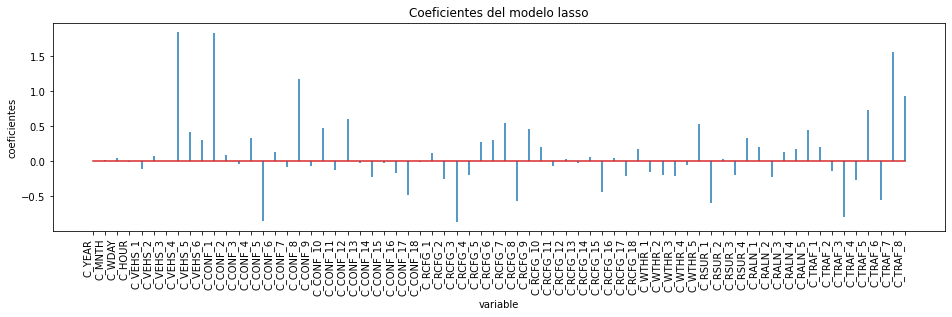

In [33]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train_t.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

In [34]:
X_train_lasso = X_train_t[selected_feat_lasso]
X_test_lasso = X_test_t[selected_feat_lasso]

### Regresión logística

In [35]:
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')
clf.fit(X_train_lasso, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [36]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [37]:
ypred = clf.predict(X_test_t[selected_feat_lasso])
ypred_proba = clf.predict_proba(X_test_t[selected_feat_lasso])

In [38]:
evaluate_model(y_test, ypred, ypred_proba)

ROC-AUC score of the model: 0.7666642229004755
Accuracy of the model: 0.8478390912057168

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.91   1440322
           1       0.63      0.21      0.32    288210

    accuracy                           0.85   1728532
   macro avg       0.75      0.59      0.62   1728532
weighted avg       0.82      0.85      0.81   1728532


Confusion matrix: 
[[1404438   35884]
 [ 227131   61079]]



Usamos el .to_parquet, para guardar las variables y poder usarlas en los siguientes scripts.

In [39]:
X_train_lasso.to_parquet("X_train.parquet")
X_test_lasso.to_parquet("X_test.parquet")
pd.DataFrame(y_train).to_parquet("ytrain.parquet")
pd.DataFrame(y_test).to_parquet("ytest.parquet")